In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,GRU, Flatten
PATH_TO_DATA="data/Sunspots.csv"
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [2]:
series = pd.read_csv(PATH_TO_DATA)
time_idx_arr=series["Unnamed: 0"].to_numpy()
sunspots_arr=series["Monthly Mean Total Sunspot Number"].to_numpy()
series["Date"]=pd.to_datetime(series["Date"])
series=series.set_index("Date")
series=series.drop(series.columns[0], axis=1)

In [3]:
series.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


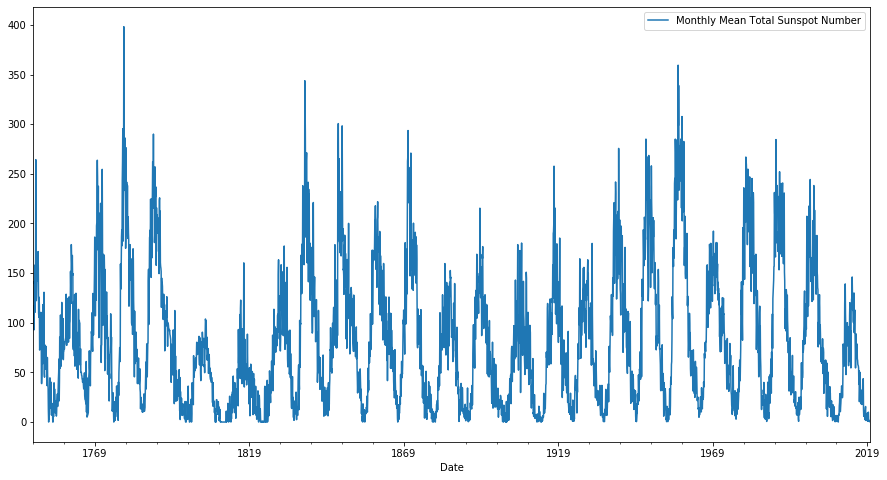

In [4]:
series.plot()
plt.show()

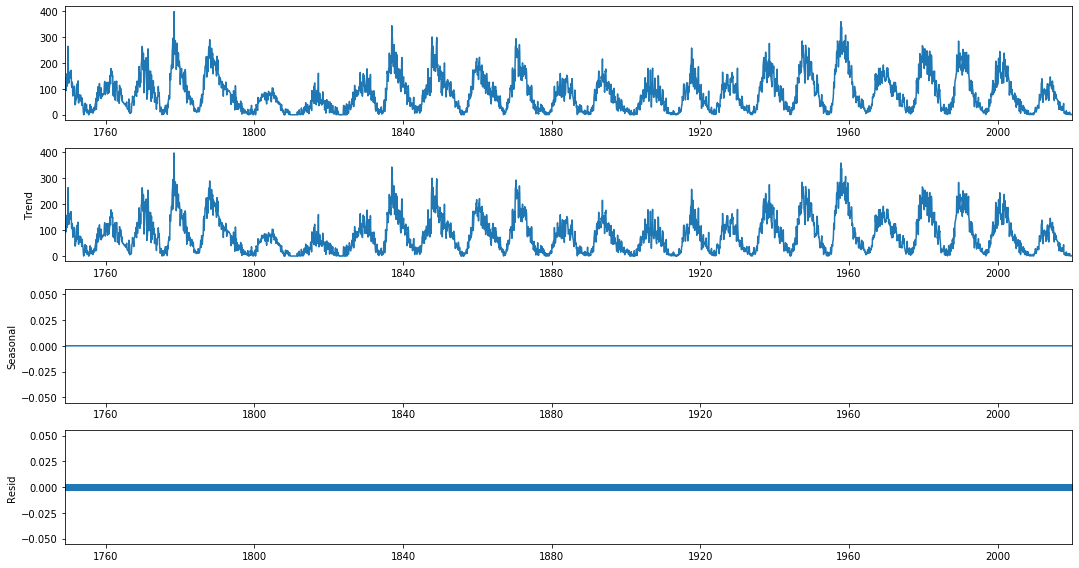

In [5]:
#y(t) = Level + Trend + Seasonality + Noise
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()

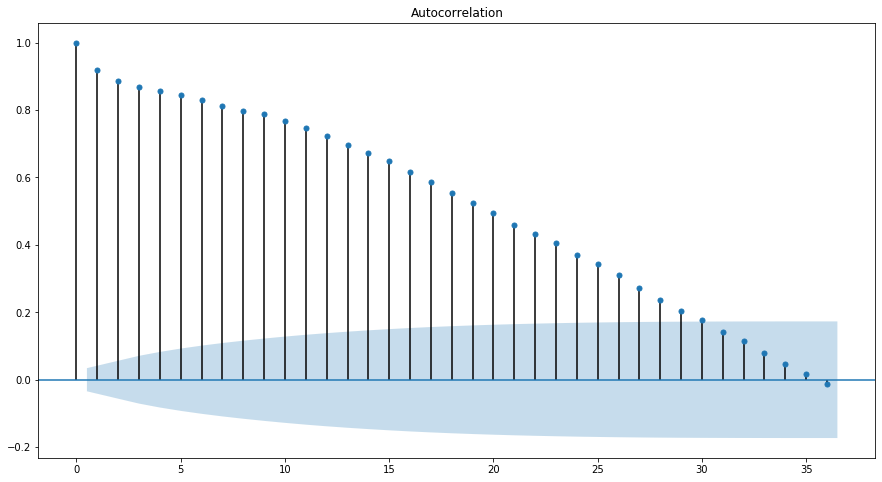

In [6]:
plot_acf(series)
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(sunspots_arr, time_idx_arr, test_size=0.3, random_state=42, shuffle=False)

C:\Users\Mikita_Ivanin\AppData\Local\Continuum\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                                      ARMA Model Results                                     
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 3252
Model:                                    ARMA(1, 2)   Log Likelihood              -15098.879
Method:                                      css-mle   S.D. of innovations             25.120
Date:                               Mon, 04 May 2020   AIC                          30207.757
Time:                                       10:03:43   BIC                          30238.192
Sample:                                   01-31-1749   HQIC                         30218.660
                                        - 12-31-2019                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                           

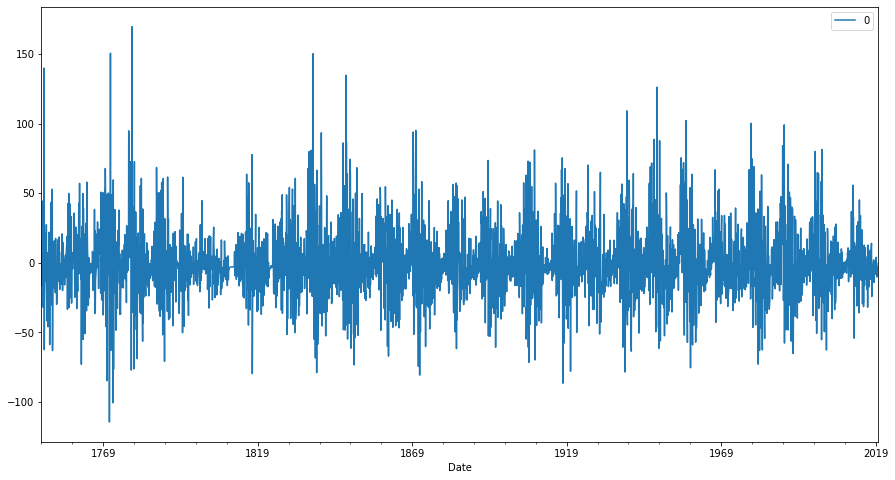

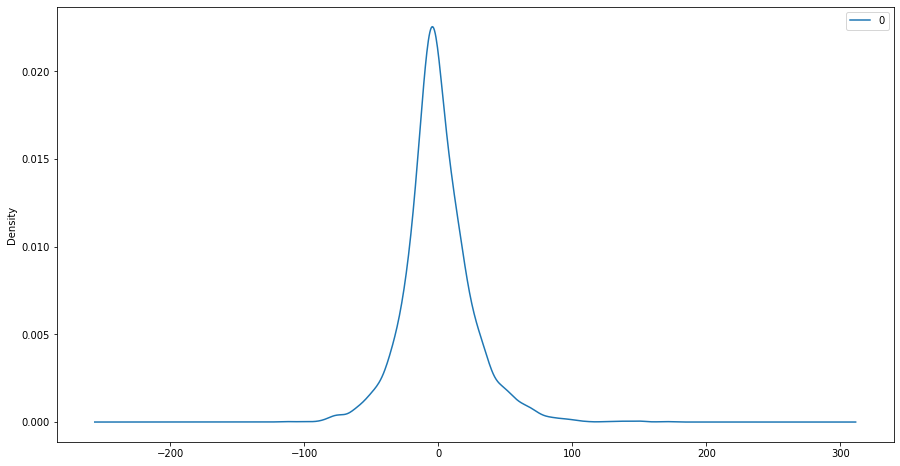

                 0
count  3252.000000
mean     -0.020786
std      25.125634
min    -114.320998
25%     -13.113150
50%      -2.305693
75%      12.051592
max     169.514062


In [8]:
model = ARIMA(series, order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [9]:
auto_arima(X_train,max_p=7, max_d=5,max_q=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2276
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -10580.723
Date:                Mon, 04 May 2020   AIC                          21171.447
Time:                        10:03:52   BIC                          21200.098
Sample:                             0   HQIC                         21181.898
                               - 2276                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4518      0.565      2.568      0.010       0.344       2.560
ar.L1          0.9819      0.004    226.134      0.000       0.973       0.990
ma.L1         -0.4332      0.016    -26.978      0.000      -0.465      -0.402
ma.L2         -0.1062      0.016     -6.611      0.000      -0.138      -0.075
sigma2       638.3002     11.481     55.599      0.000     615.799     660.802
===================================================================================
Ljung-Box (Q):                      122.27   Jarque-Bera (JB):              1598.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.67
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
history = X_train.tolist()
arima_predictions = []
for t in range(len(X_test)):
    model = SARIMAX(history, order = (1,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
error = mean_squared_error(X_test, arima_predictions)
print(f"Test MSE: {error}")
print(f"Test RMSE: {np.sqrt(error)}")

Test MSE: 617.3789036554884
Test RMSE: 24.847110569550907


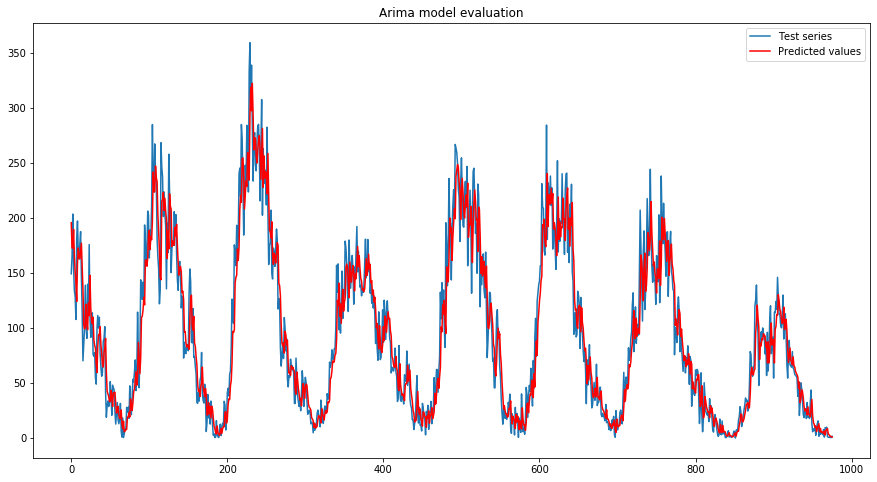

In [11]:
plt.plot(X_test, label="Test series")
plt.plot(arima_predictions, color="red", label="Predicted values")
plt.title("Arima model evaluation")
plt.legend()
plt.show()

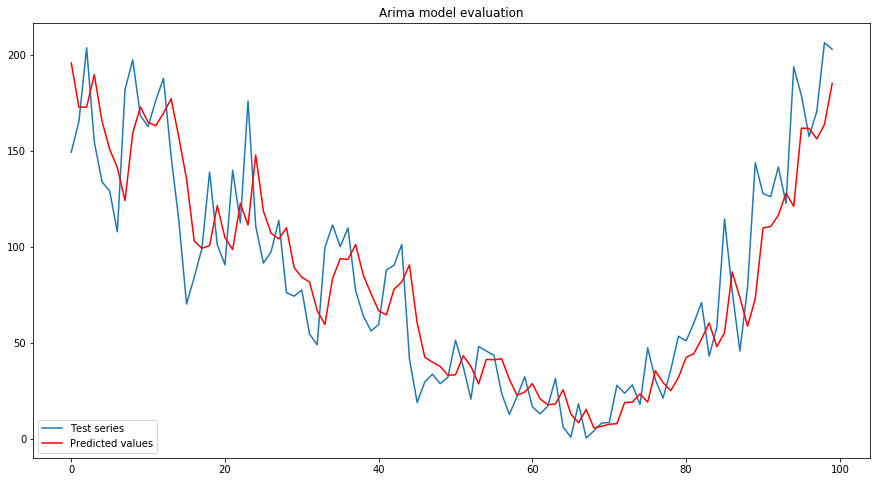

In [13]:
plt.plot(X_test[:100], label="Test series")
plt.plot(arima_predictions[:100], color="red", label="Predicted values")
plt.title("Arima model evaluation")
plt.legend()
plt.show()

In [14]:
n_input = 1
n_features = 1
scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1, 1))
X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
X_test_scaled = scaler.transform(X_test.reshape(-1, 1))
generator = TimeseriesGenerator(X_train_scaled[:-500], X_train_scaled[:-500], length=n_input, batch_size=32)
generator_valid = TimeseriesGenerator(X_train_scaled[-500:], X_train_scaled[-500:], length=n_input, batch_size=32)
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
lstm_model.add(LSTM(200, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 200)            161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 200)            320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [15]:
callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)]
lstm_model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=1, validation_data=generator_valid, callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 16 steps
Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.1441 - val_loss: 0.0499
Epoch 2/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0125 - val_loss: 0.0492
Epoch 3/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0050 - val_loss: 0.0485
Epoch 4/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0469 - val_loss: 0.0478
Epoch 5/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0473 - val_loss: 0.0470
Epoch 6/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1702 - val_loss: 0.0462
Epoch 7/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0872 - val_loss: 0.0453
Epoch 8/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0147 - val_loss: 0.0444
Epoch 9/500
1/1 [==============================] - 

Epoch 80/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0053 - val_loss: 0.0167
Epoch 81/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0112 - val_loss: 0.0167
Epoch 82/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0034 - val_loss: 0.0168
Epoch 83/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0150 - val_loss: 0.0169
Epoch 84/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0074 - val_loss: 0.0169
Epoch 85/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0030 - val_loss: 0.0170
Epoch 86/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0263 - val_loss: 0.0170
Epoch 87/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0062 - val_loss: 0.0169
Epoch 88/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0048 - val_loss: 0.0169
Epoch 89/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0048 - val_loss: 0.0168
Epoch 90/5

1/1 [==============================] - 0s 51ms/step - loss: 0.0333 - val_loss: 0.0088
Epoch 163/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0044 - val_loss: 0.0087
Epoch 164/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 165/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0045 - val_loss: 0.0085
Epoch 166/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 167/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 168/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0043 - val_loss: 0.0085
Epoch 169/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0049 - val_loss: 0.0084
Epoch 170/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0042 - val_loss: 0.0084
Epoch 171/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 172/500


1/1 [==============================] - 0s 49ms/step - loss: 0.0025 - val_loss: 0.0052
Epoch 245/500
1/1 [==============================] - 0s 48ms/step - loss: 9.0688e-04 - val_loss: 0.0052
Epoch 246/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 247/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0140 - val_loss: 0.0052
Epoch 248/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0152 - val_loss: 0.0051
Epoch 249/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 250/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 251/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 252/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 253/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 254/

Epoch 326/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 327/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 328/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 329/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 330/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0072 - val_loss: 0.0049
Epoch 331/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 332/500
1/1 [==============================] - 0s 47ms/step - loss: 8.8465e-04 - val_loss: 0.0049
Epoch 333/500
1/1 [==============================] - 0s 48ms/step - loss: 9.9467e-04 - val_loss: 0.0049
Epoch 334/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 335/500
1/1 [==============================] - 0s 47ms/step - loss: 8.0465e-04 - val_l

Epoch 408/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 409/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 410/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 411/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 412/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 413/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0101 - val_loss: 0.0046
Epoch 414/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 415/500
1/1 [==============================] - 0s 64ms/step - loss: 8.3845e-04 - val_loss: 0.0046
Epoch 416/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 417/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0113 - val_loss: 0.0

Epoch 490/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 491/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 492/500
1/1 [==============================] - 0s 48ms/step - loss: 4.8129e-04 - val_loss: 0.0046
Epoch 493/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 494/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 495/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 496/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 497/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 498/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0098 - val_loss: 0.0045
Epoch 499/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0034 - val_loss: 0.0

In [16]:
def plot_history(history):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.legend()    
    plt.show()

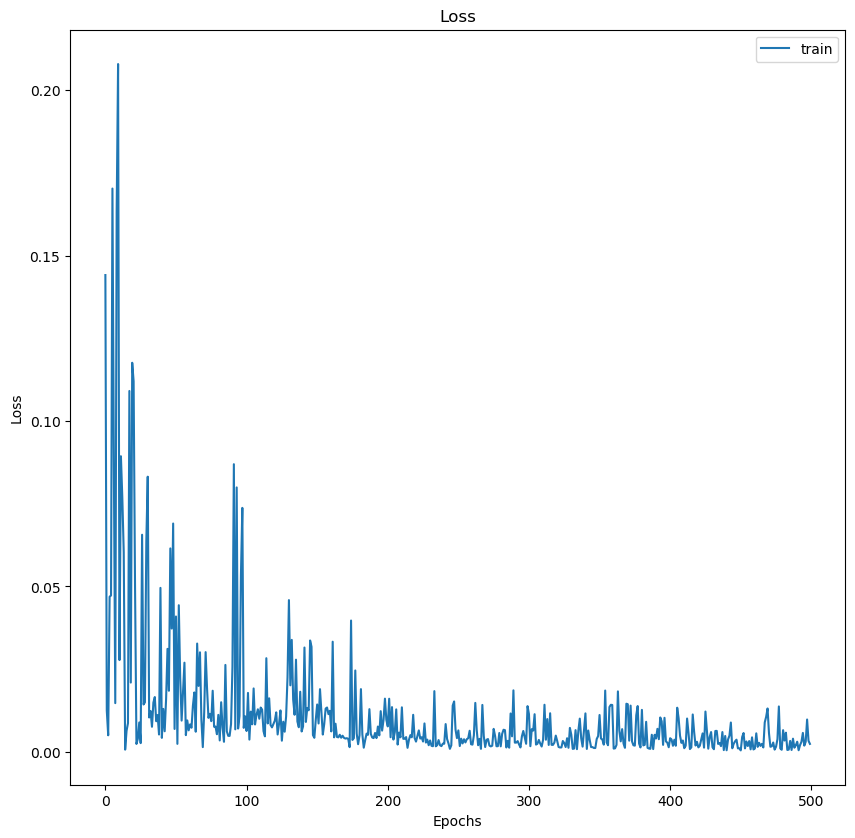

In [17]:
plot_history(lstm_model.history)

In [18]:
lstm_y_pred=np.array([])
y_true=np.array([])
generator_test = TimeseriesGenerator(X_test_scaled, X_test_scaled, length=n_input, batch_size=8)
for x,y in generator_test:   
    lstm_pred = lstm_model.predict(x.reshape((x.shape[0], x.shape[1], 1)))
    lstm_y_pred=np.concatenate((lstm_y_pred, np.array(lstm_pred).reshape((len(lstm_pred),))))
    y_true=np.concatenate((y_true, y.reshape((y.shape[0],))))
lstm_y_pred=scaler.inverse_transform(lstm_y_pred.reshape(-1, 1))
y_true=scaler.inverse_transform(y_true.reshape(-1, 1))

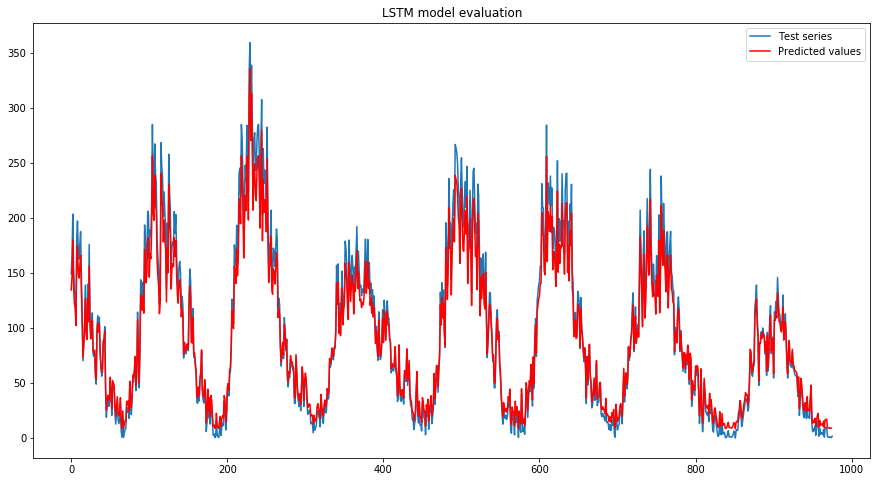

In [20]:
plt.plot(X_test, label="Test series")
plt.plot(lstm_y_pred, color="red", label="Predicted values")
plt.title("LSTM model evaluation")
plt.legend()
plt.show()

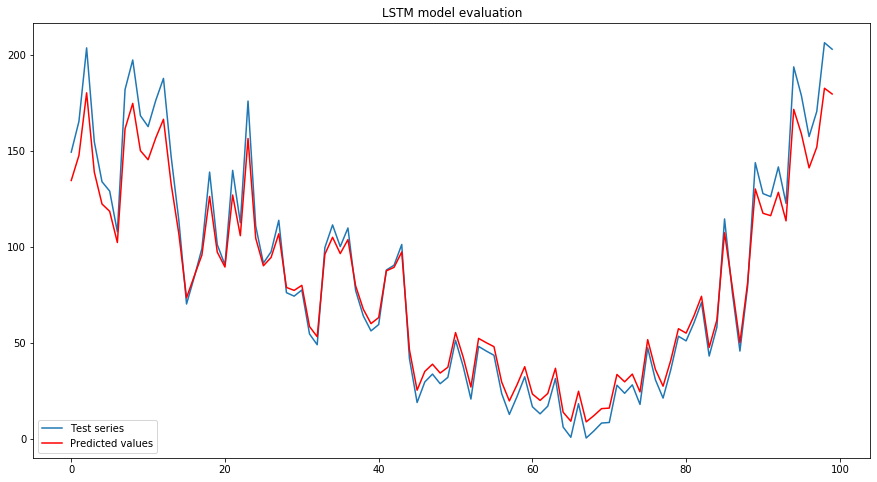

In [21]:
plt.plot(X_test[:100], label="Test series")
plt.plot(lstm_y_pred[:100], color="red", label="Predicted values")
plt.title("LSTM model evaluation")
plt.legend()
plt.show()

In [22]:
error = mean_squared_error(y_true, lstm_y_pred)
print(f"Test MSE: {error}")
print(f"Test RMSE: {np.sqrt(error)}")

Test MSE: 766.5694716124085
Test RMSE: 27.686991017667637


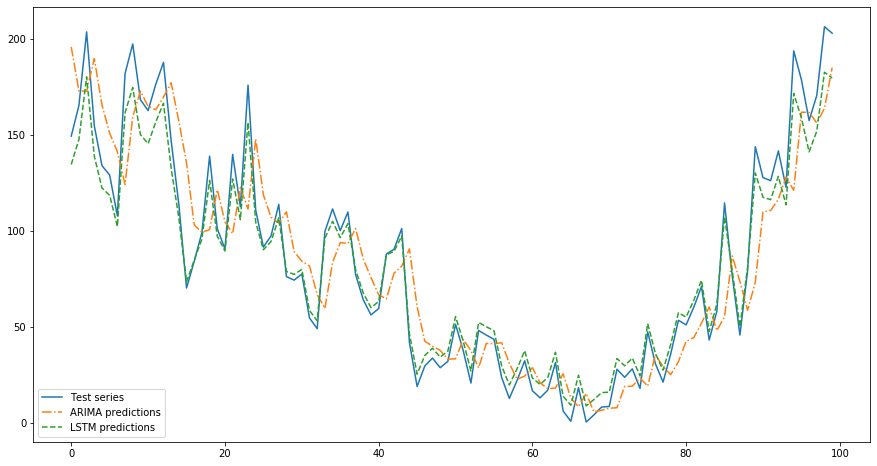

In [23]:
plt.plot(X_test[:100], label="Test series", linestyle="-")
plt.plot(arima_predictions[:100], label="ARIMA predictions", linestyle="-.")
plt.plot(lstm_y_pred[:100], label="LSTM predictions", linestyle="--")
plt.legend()
plt.show()